In [29]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

# 6.1 - Initialization

In [30]:
#(a) Load the sound files. Each of the N = 2 sources is sampled at at 8192 Hz and contains p = 18000 samples.
s = np.array([np.loadtxt("sound1.dat"), np.loadtxt("sound2.dat")])
N = s.shape[0]

In [31]:
#(b) Create a random (& invertible) N ×N mixing matrix A and mix the sources: x(α) = As(α)
A = np.zeros((N, N))

#Use any mixing matrix (good and bad results)
while np.linalg.det(A) == 0:
    A = np.random.uniform(0.0, 1.0, (N, N))
#Force "good enough" mixing matrix (only good results)
#while np.linalg.det(A) < .8:
#    A = np.random.uniform(0.0, 1.0, (N, N))
#Force "good enough" mixing matrix (only good results), but flip sources
#while np.linalg.det(A) == 0 or  np.linalg.det(A) > -.7:
#    A = np.random.uniform(0.0, 1.0, (N, N))

print("Mixing Matrix:\n"+str(A)+"\nDet: "+str(np.linalg.det(A)))
x = np.dot(A, s)
#print(x.shape)
#print(x)

Mixing Matrix:
[[ 0.98053912  0.42512827]
 [ 0.21309157  0.90119725]]
Det: 0.793067904584


In [32]:
#(c) Remove the temporal structure by permuting the columns of the N × p matrix X randomly.
xs = np.random.permutation(x)
#print(xs)

In [33]:
#(d) Calculate the correlations between the sources and the mixtures: ρ(si,xj) = cov(si,xj) / (σsi*σxj)
#p = np.cov(s, x) / (np.var(s) * np.var(x))
#print(p)
#p = [((np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))[0,1],i,j) for i in range(N) for j in range(N)]
#print(p)
def buildcorrelations(N, s, x):
    p = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            #print("i: "+str(i)+" j: "+str(j)+" corr:\n"+str((np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))))
            p[i, j] = (np.cov(s[i], x[j]) / (np.std(s[i]) * np.std(x[j])))[0,1]
    return p
print(buildcorrelations(N, s, x))

[[ 0.91756337  0.23121553]
 [ 0.39888546  0.97325031]]


In [34]:
#(e) Center the data to zero mean.
#print( np.mean(x, axis=1).shape )
x_mean = np.mean(xs, axis=1).reshape(-1,1)
xsc = xs - x_mean
#print(xsc.shape)

In [35]:
#(f) Initialize the unmixing matrix W with random values.
#s = W.x, s: Nxp, x: Nxp -> W: NxN
W = np.random.uniform(0, 1, (N, N))

# 6.2 - Optimization

In [36]:
def fhat(y):
    return 1 / (1 + np.exp(-y))
def fhatpp_fhatp(y):
    return 1 - 2*fhat(y)

In [37]:
#(a) Compute the update matrix ∆W using the “regular” gradient.
def dW(eta, W, x):
    #x0 x1
    #x0 x1
    xv = np.vstack( (x.T, x.T) )
    #x0 x0
    #x1 x1
    xh = np.hstack( (x.reshape(-1,1), x.reshape(-1,1)) )
    #W-1 + f(W . xh) * xv
    return eta * (np.linalg.pinv(W).T + np.multiply( fhatpp_fhatp(np.dot(W, xh)), xv))

In [38]:
#(b) Compute the update matrix ∆W using the natural gradient as described in the lecture notes.
def dWnatural(eta, W, x):
    #x0 x1
    #x0 x1
    xv = np.vstack( (x.T, x.T) )
    #x0 x0
    #x1 x1
    xh = np.hstack( (x.reshape(-1,1), x.reshape(-1,1)) )
    #W-1 + f(W . xh) * xv
    subtotal = (np.eye(W.shape[0]) + np.multiply( fhatpp_fhatp(np.dot(W, xh)), xv))
    #return eta * np.dot(subtotal, np.dot(W.T, W))
    return eta * np.dot(subtotal, W)

In [39]:
#(c) Choose a suitable learning rate η and apply both versions to the data to unmix the sources.
eta = .2
epsilon = .001
Wa = W.copy()
Wb = W.copy()
Wbbs = W.copy()
AConverged = False
BConverged = False
BbsConverged = False
ssa_for_6_3_d = []
ssb_for_6_3_d = []
ssbbs_for_6_3_d = []
print("Initial W:\n"+str(W))
for t in range(1,18000):
    xa = xsc[:,np.random.randint(xsc.shape[1])]

    #Regular
    if not AConverged:
        regular = dW(eta/float(t), Wa, xa)
        if regular.any() > epsilon:
            Wa = Wa + regular
            if t%1000 == 0:
                ssa_for_6_3_d.append(np.sum(np.power(Wa,2)))
        else:
            AConverged = True
            print("(a) converged at: "+str(t))
    else:
        pass
    
    #Natural
    if not BConverged:
        natural = dWnatural(eta/float(t), Wb, xa)
        if natural.any() > epsilon:
            Wb = Wb + natural
            if t%1000 == 0:
                ssb_for_6_3_d.append(np.sum(np.power(Wb,2)))
        else:
            BConverged = True
            print("(b) converged at: "+str(t))
    
    #Natural with Bell-Sejnowski regularization
    if not BbsConverged:
        naturalbs = dWnatural(eta/float(t), Wbbs, xa)
        for n in range(N):
            naturalbs[n, n] = 0
        if naturalbs.any() > epsilon:
            Wbbs = Wbbs + naturalbs
            for n in range(N):
                Wbbs[n, n] = 1
            if t%1000 == 0:
                ssbbs_for_6_3_d.append(np.sum(np.power(Wbbs,2)))
        else:
            BbsConverged = True
            print("(b) Bell-Sejnowski converged at: "+str(t))
    else:
        pass
print("Wa:\n"+str(Wa))
print("Wb:\n"+str(Wb))
print("Wbbs:\n"+str(Wbbs))

Initial W:
[[ 0.56532494  0.24063302]
 [ 0.31084711  0.23080446]]
Wa:
[[ 1.90605521 -0.78409524]
 [-0.52472215  2.30239696]]
Wb:
[[ 1.51758917  0.39467623]
 [ 0.34317213  0.68319023]]
Wbbs:
[[ 1.          0.03374401]
 [ 0.14133872  1.        ]]


# 6.3 - Results

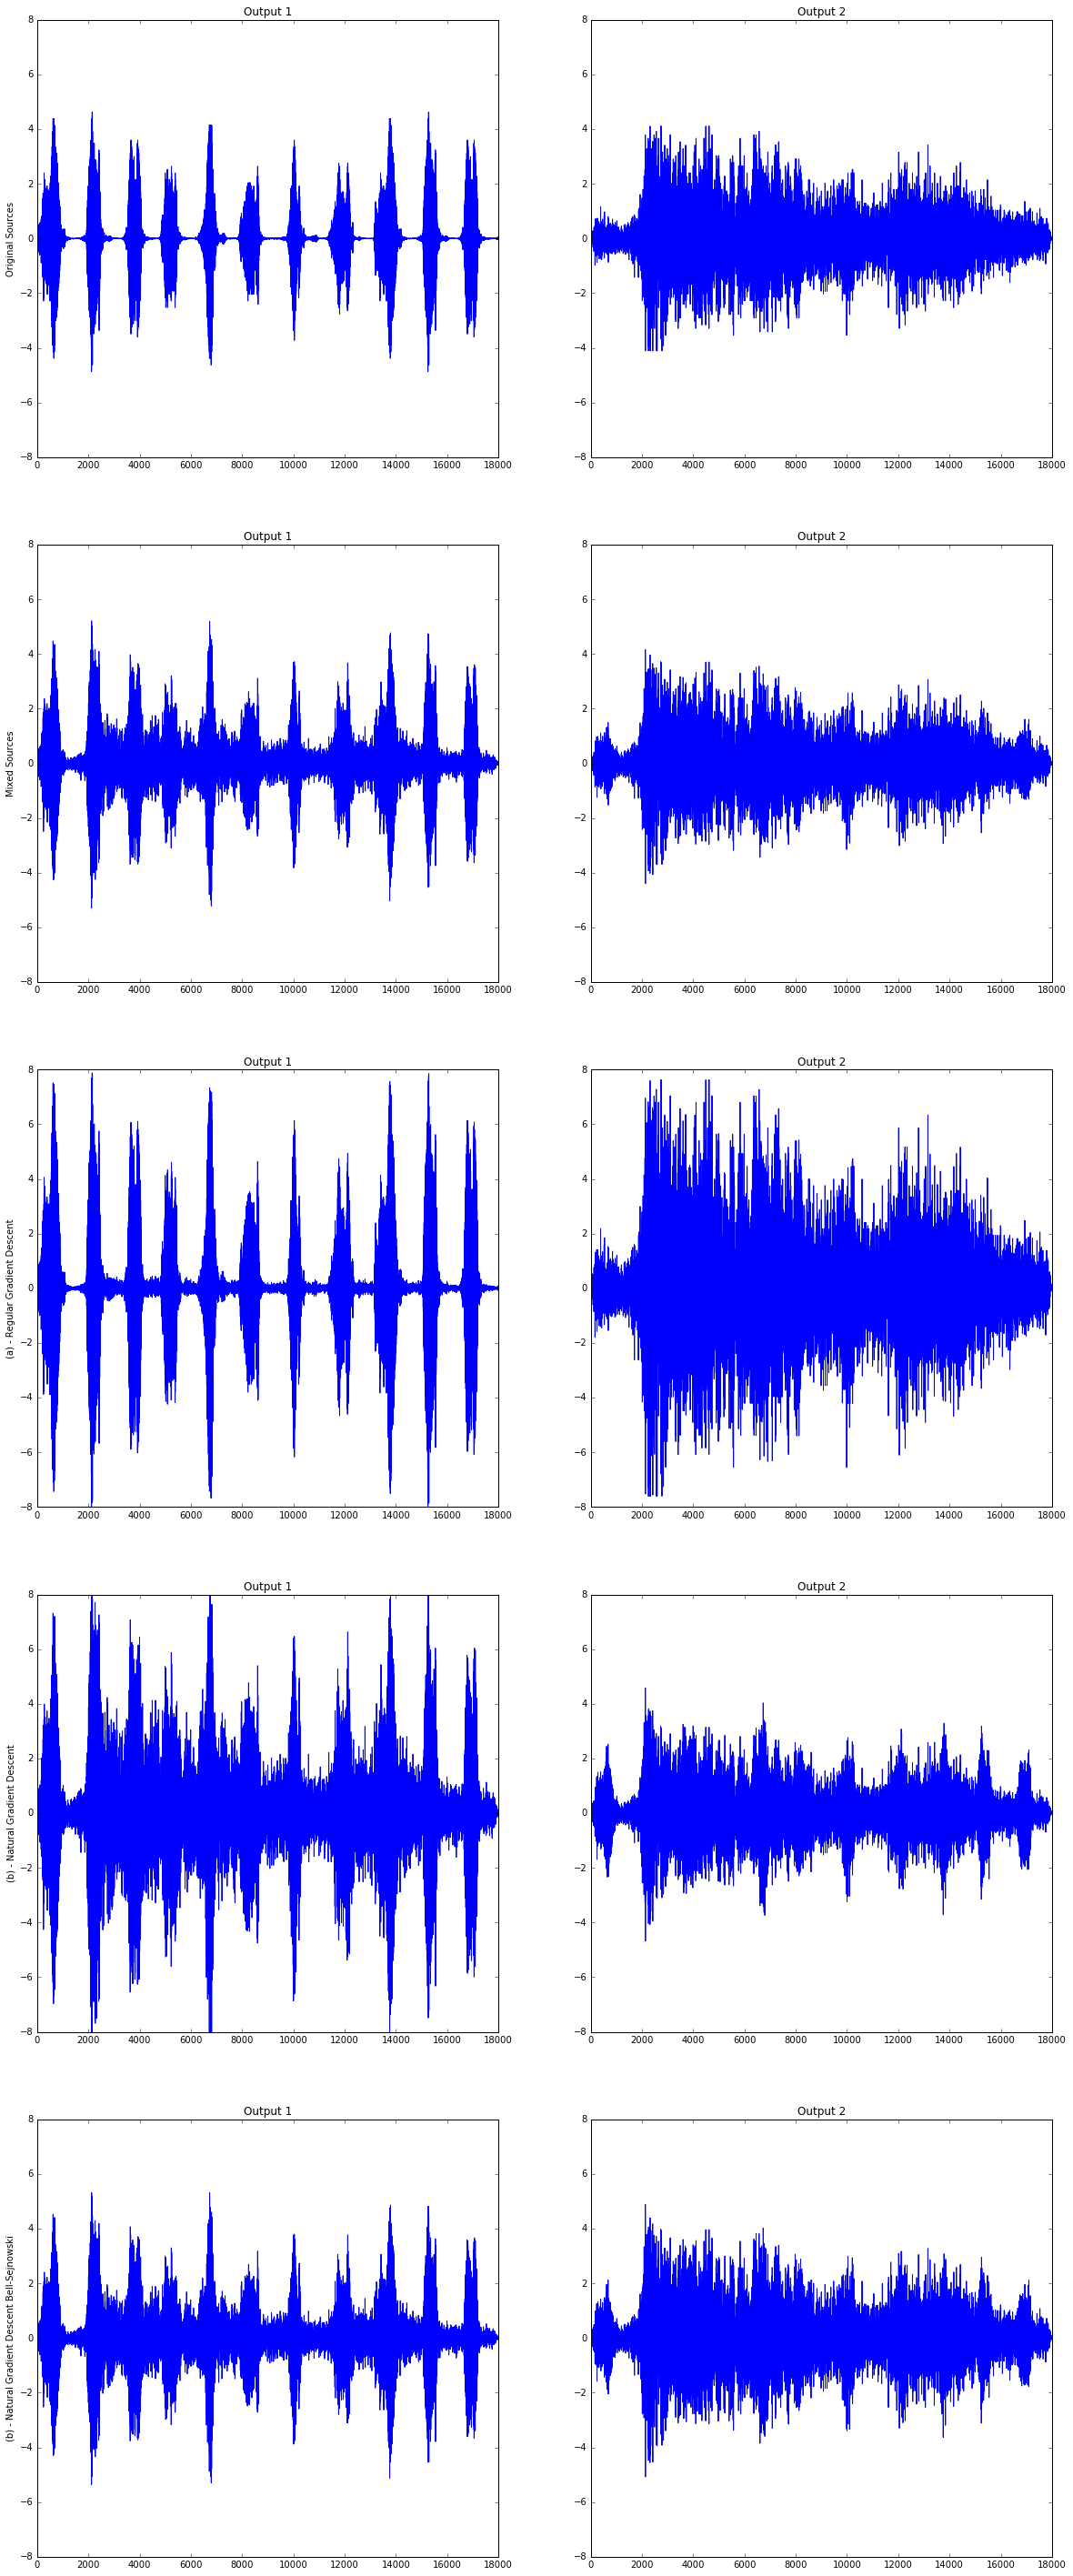

In [40]:
#(a) Plot & Play 
#(i) the original sounds (e.g. use scipy.io.wavfile to save playable files), 
#(ii) the mixed sources (before and after the data permutation), 
#and the recovered signals (estimated sources) ˆs = Wx using the unpermuted data.

#retrieve shats - ^s
shata = np.dot(Wa, x)
shata_decentered = shata + x_mean
shatb = np.dot(Wb, x)
shatb_decentered = shatb + x_mean
shatbbs = np.dot(Wbbs, x)
shatbbs_decentered = shatbbs + x_mean

#Check correlations, to check whcih source goes to which output channel
mixcors = buildcorrelations(N, s, x)
regularcors = buildcorrelations(N, shata_decentered, s)
naturalcors = buildcorrelations(N, shatb_decentered, s)
naturalbscors = buildcorrelations(N, shatbbs_decentered, s)

isflippedmixes = (mixcors[0,0] < mixcors[0,1]) and (mixcors[1,0] > mixcors[1,1])
isflippedregular = (regularcors[0,0] < regularcors[0,1]) and (regularcors[1,0] > regularcors[1,1])
isflippednatural = (naturalcors[0,0] < naturalcors[0,1]) and (naturalcors[1,0] > naturalcors[1,1])
isflippednaturalbs = (naturalbscors[0,0] < naturalbscors[0,1]) and (naturalbscors[1,0] > naturalbscors[1,1])

ys = [(s, 'Original Sources', False), 
      (x, 'Mixed Sources', isflippedmixes), 
      (shata_decentered, '(a) - Regular Gradient Descent', isflippedregular), 
      (shatb_decentered, '(b) - Natural Gradient Descent', isflippednatural), 
      (shatbbs_decentered, '(b) - Natural Gradient Descent Bell-Sejnowski', isflippednaturalbs)]
ylimits = [-8,8]
f, axarr = plt.subplots(len(ys), 2)
f.set_size_inches(20, len(ys)*10, forward=False) 

axarr[0, 0].set_title("Source 1")
axarr[0, 1].set_title("Source 2")

for r in range(len(ys)):
    axarr[r, 0].set_ylim(ylimits)
    axarr[r, 1].set_ylim(ylimits)
    axarr[r, 0].set_ylabel(ys[r][1])
    if not ys[r][2]:
        axarr[r, 0].plot(range(ys[r][0].shape[1]), ys[r][0][0])
        axarr[r, 1].plot(range(ys[r][0].shape[1]), ys[r][0][1])
        axarr[r, 0].set_title("Output 1")
        axarr[r, 1].set_title("Output 2")
    else:
        axarr[r, 0].plot(range(ys[r][0].shape[1]), ys[r][0][1])
        axarr[r, 1].plot(range(ys[r][0].shape[1]), ys[r][0][0])
        axarr[r, 0].set_title("Output 2 (Flipped)")
        axarr[r, 1].set_title("Output 1 (Flipped)")
plt.show()

In [41]:
#(b) Calculate the correlations (as above) between the true sources and the estimations.

print("\nMixes")
print(mixings)
print("\nRegular")
print(regularcors)
print("\nNatural")
print(naturalcors)
print("\nNatural with Bell-Sejnowski")
print(naturalbscors)


Mixes
[[ 0.98491629  0.64562778]
 [ 0.17459354  0.76453815]]

Regular
[[ 0.99820359  0.06209157]
 [-0.01163575  0.9999724 ]]

Natural
[[ 0.84373447  0.53792731]
 [ 0.53551894  0.8452633 ]]

Natural with Bell-Sejnowski
[[ 0.90817119  0.41987599]
 [ 0.34454243  0.93926344]]


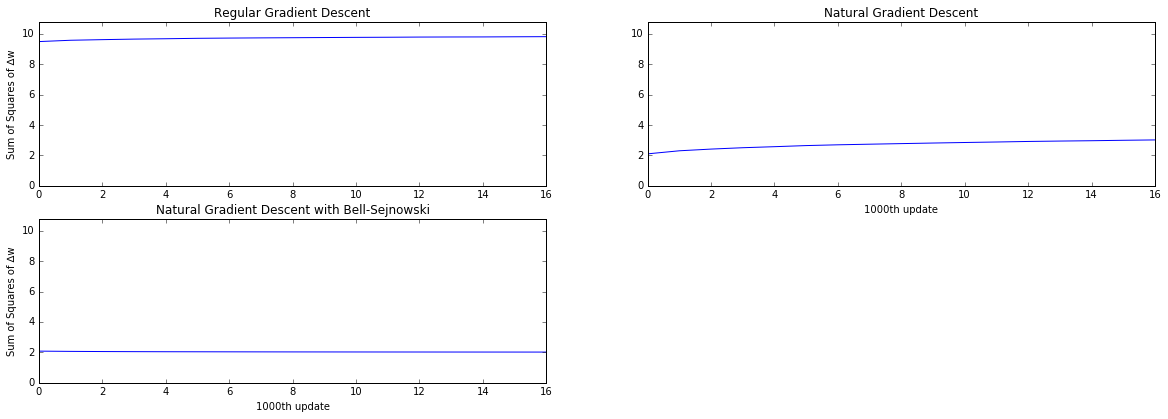

In [42]:
#(c) For every 1000th update, plot ||∆W||2F :=  Ni=1,j=1(∆wi,j)2 to compare the convergence speed for the two gradient methods. 
#Whiten your data before applying ICA and compare the learning speeds again. 
#Describe the differences between the two variants of the learning algorithm.

#print(ssa_for_6_3_d)
#print(ssb_for_6_3_d)

maxy = np.max([np.max(ssa_for_6_3_d), np.max(ssb_for_6_3_d), np.max(ssbbs_for_6_3_d)])
maxy = maxy*1.1 #add some space

fig = plt.figure(figsize=(20,10))
ylimits = [0, maxy]

ax1 = plt.subplot(321)
ax1.plot(range(len(ssa_for_6_3_d)), ssa_for_6_3_d)
plt.title('Regular Gradient Descent')
plt.ylabel('Sum of Squares of ∆w')
#plt.xlabel('1000th update')
ax1.set_ylim(ylimits)

ax2 = plt.subplot(322)
ax2.plot(range(len(ssb_for_6_3_d)), ssb_for_6_3_d)
plt.title('Natural Gradient Descent')
plt.xlabel('1000th update')
ax2.set_ylim(ylimits)

ax3 = plt.subplot(323)
ax3.plot(range(len(ssbbs_for_6_3_d)), ssbbs_for_6_3_d)
plt.title('Natural Gradient Descent with Bell-Sejnowski')
plt.ylabel('Sum of Squares of ∆w')
plt.xlabel('1000th update')
ax3.set_ylim(ylimits)
plt.show()


In [43]:
#(d) Plot the density of the mixed, unmixed, and true signals & interpret your results.

In [44]:
#Measure of goodness : compare W.A with A-1 . A
print(np.dot(np.linalg.pinv(A), A))
print(np.power(np.eye(2) - np.dot(W, A),2).sum())

[[  1.00000000e+00   2.22044605e-16]
 [ -1.66533454e-16   1.00000000e+00]]
0.925280836026
